## 3.4. Random Forests

---

In [1]:
import sys
sys.path.insert(1, '../../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import train_test_split

n_samples = 5
samples = []

for i in range(n_samples):
    dataTrain: pd.DataFrame = pd.read_csv('data/prepared_b_sample/data%d.csv' %i, sep=';')
    dataTest: pd.DataFrame = pd.read_csv('data/prepared_test_sample/data%d.csv' %i, sep=';')
        
    samples.append({'dataTrain': dataTrain, 'dataTest': dataTest})

    dataTest_copy = samples[i]['dataTest'].copy(deep=True)

    for feature in dataTest_copy.columns:
        if feature not in samples[i]['dataTrain'].columns:
            samples[i]['dataTest'] = samples[i]['dataTest'].drop(feature, axis=1)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingClassifier
import ds_functions as ds

target = 'exp'

my_samples=[]

for i in range(n_samples):
    trnY = samples[i]['dataTrain'].pop(target).values
    trnX = samples[i]['dataTrain'].values
    tstY = samples[i]['dataTest'].pop(target).values
    tstX = samples[i]['dataTest'].values
    
    my_samples.append({'X_train': trnX, 'X_test': tstX,
                  'y_train': trnY, 'y_test': tstY})
    
labels = [False, True]

<Figure size 600x450 with 0 Axes>

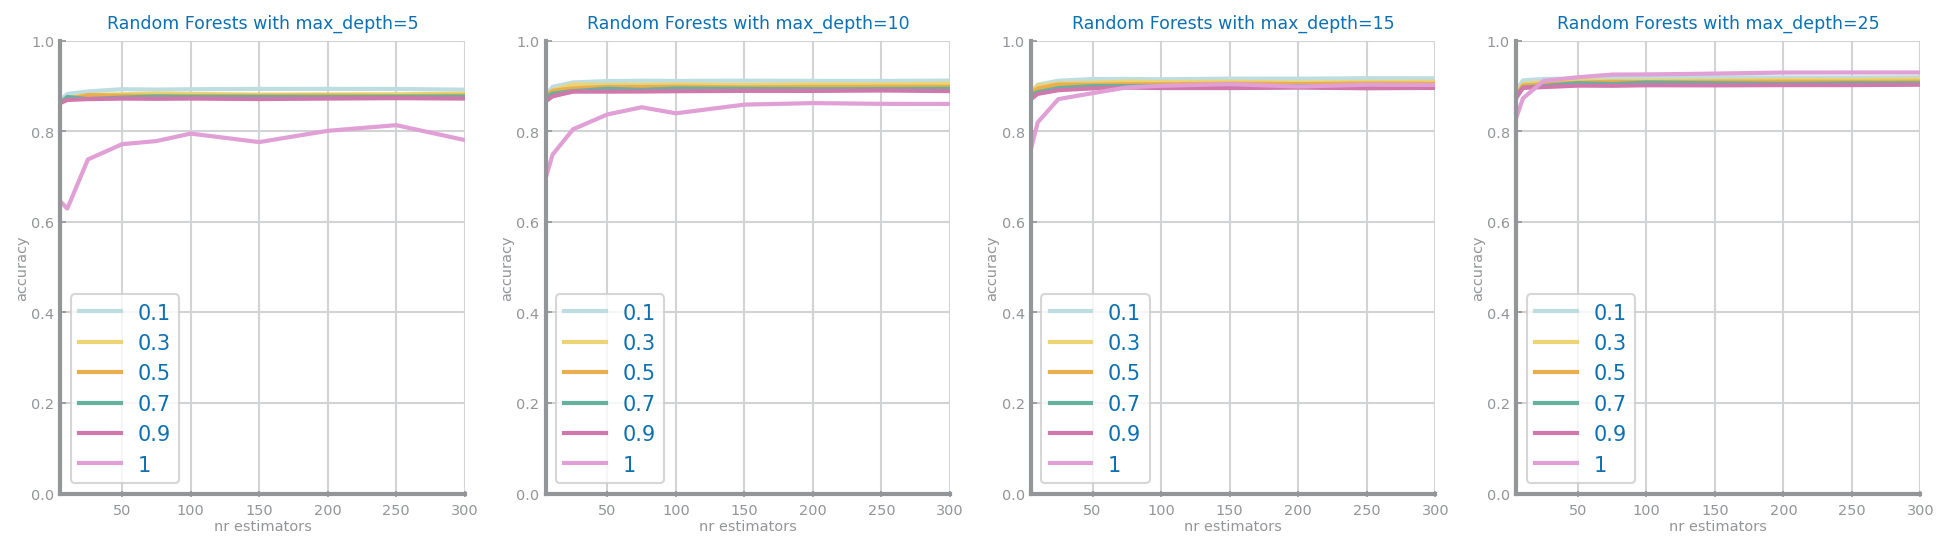

Best results with depth=25, 1.000000 features and 250 estimators, with accuracy=0.933655
Best results per sample:
	Sample 0: depth=25 , 1.000000 features and 200 estimators ==> accuracy=0.924759
	Sample 1: depth=25 , 1.000000 features and 250 estimators ==> accuracy=0.931431
	Sample 2: depth=25 , 1.000000 features and 300 estimators ==> accuracy=0.930319
	Sample 3: depth=25 , 1.000000 features and 300 estimators ==> accuracy=0.931801
	Sample 4: depth=25 , 1.000000 features and 250 estimators ==> accuracy=0.933655


In [3]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 15, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = (0, 0, 0) #(depth, feature, estimators)
last_best = 0
best_forest = None
best_sample = None
best_sampl = 0

sample_best = [('',  0, 0.0)] * n_samples
sample_best_forest = [None] * n_samples
sample_last_best = [0] * n_samples

model_rf = []
for sample in my_samples:
    model_rf.append(0)

cols = len(max_depths)

plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)

for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        values[f] = []
        for i in range(len(n_estimators)):
            values[f].append(0)
    for sampl in range(n_samples):
        sample = my_samples[sampl]
        for f in max_features:
            yvalues = []
            for n in n_estimators:
                rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
                model = rf.fit(sample['X_train'], sample['y_train'])
                sample['prdY'] = rf.predict(sample['X_test'])
                yvalues.append(metrics.accuracy_score(sample['y_test'], sample['prdY']))
                                               
                # Check if accuracy is better than best overall
                if yvalues[-1] > last_best:
                    best = (d, f, n)
                    last_best = yvalues[-1]
                    best_forest = rf
                    best_sample = sample
                    best_sampl = sampl
                                               
                # Check if accuracy is better than best in current sample
                if yvalues[-1] > sample_last_best[sampl]:
                    sample_best[sampl] = (d, f, n)
                    sample_last_best[sampl] = yvalues[-1]
                    sample_best_forest[sampl] = rf
                    model_rf[sampl] = model
                                               
            # Increment total accuracy for current (max_depth, min_impurity decrease)
            for i in range(len(yvalues)):
                values[f][i] += yvalues[i]
    # Normalize
    for v in values:
        for i in range(len(values[v])):
            values[v][i] /= n_samples
            
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with depth=%d, %f features and %d estimators, with accuracy=%f'%(best[0], best[1], best[2], last_best))

print('Best results per sample:')
for i in range(n_samples):
    print('\tSample %d: depth=%d , %f features and %d estimators ==> accuracy=%f' % (i, *sample_best[i], sample_last_best[i]))

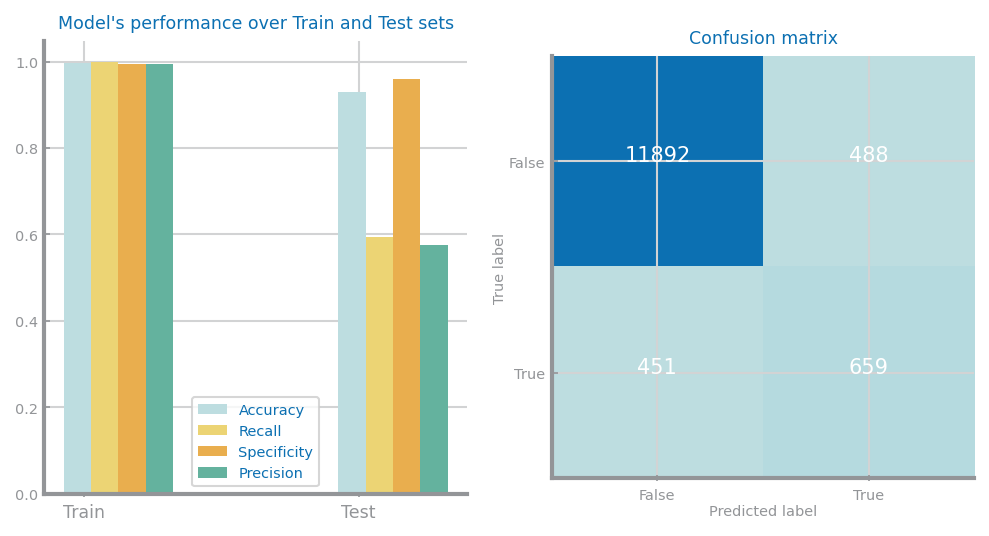

In [4]:
y_train_all = []
prd_train_all = []
y_test_all = []
prd_test_all = []

for i in range(n_samples):
    y_train_all.extend(my_samples[i]['y_train'])
    prd_train_all.extend(sample_best_forest[i].predict(my_samples[i]['X_train']))
    y_test_all.extend(my_samples[i]['y_test'])
    prd_test_all.extend(sample_best_forest[i].predict(my_samples[i]['X_test']))

ds.plot_evaluation_results(labels, y_train_all, prd_train_all, y_test_all, prd_test_all, showXTickLabels=True)

<Figure size 600x450 with 0 Axes>

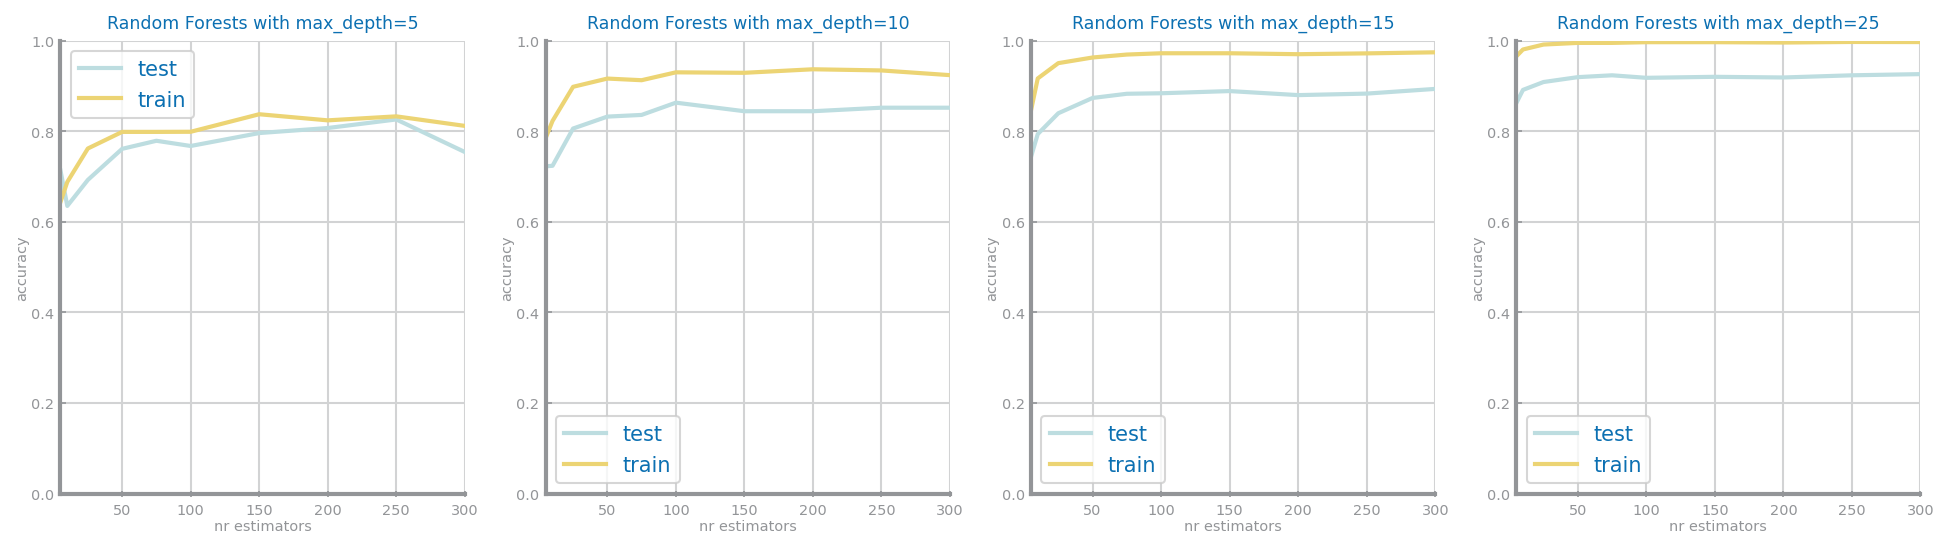

<Figure size 600x450 with 0 Axes>

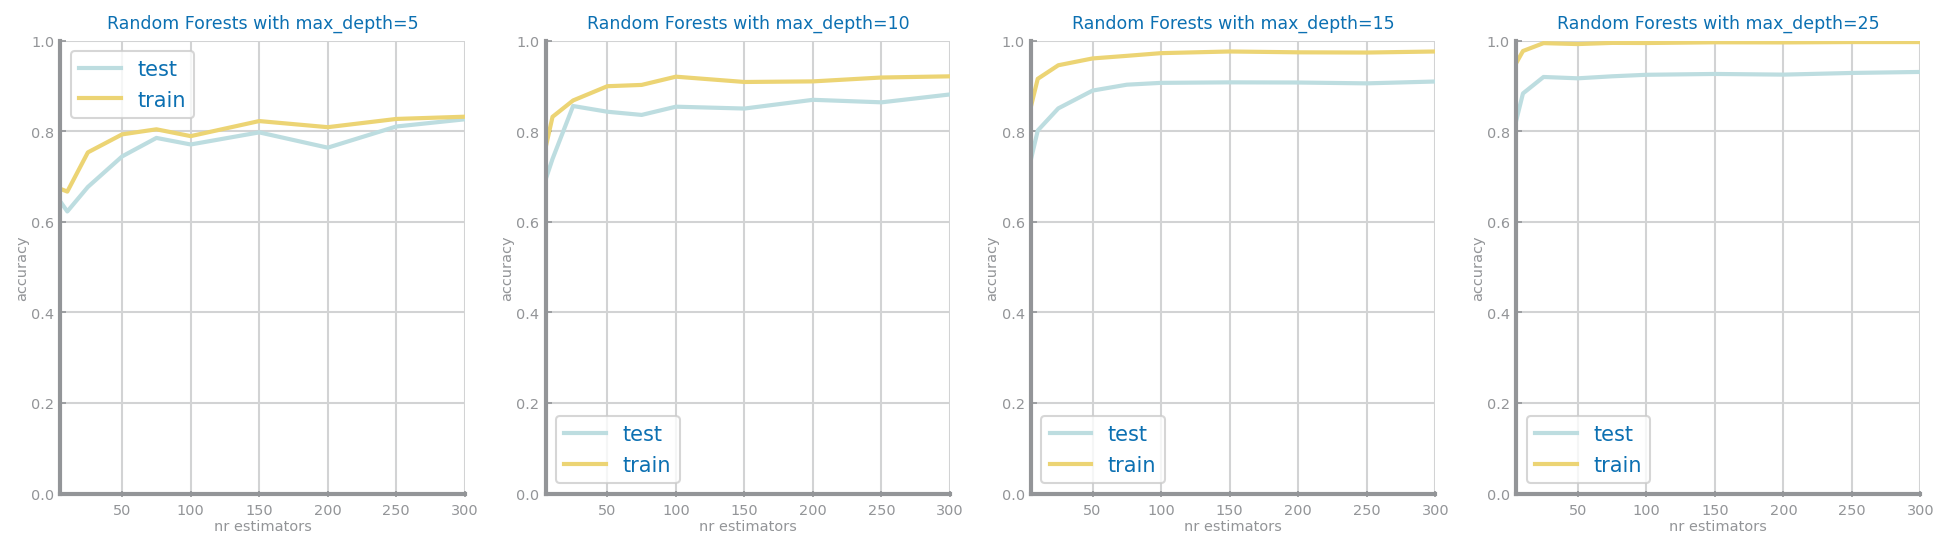

<Figure size 600x450 with 0 Axes>

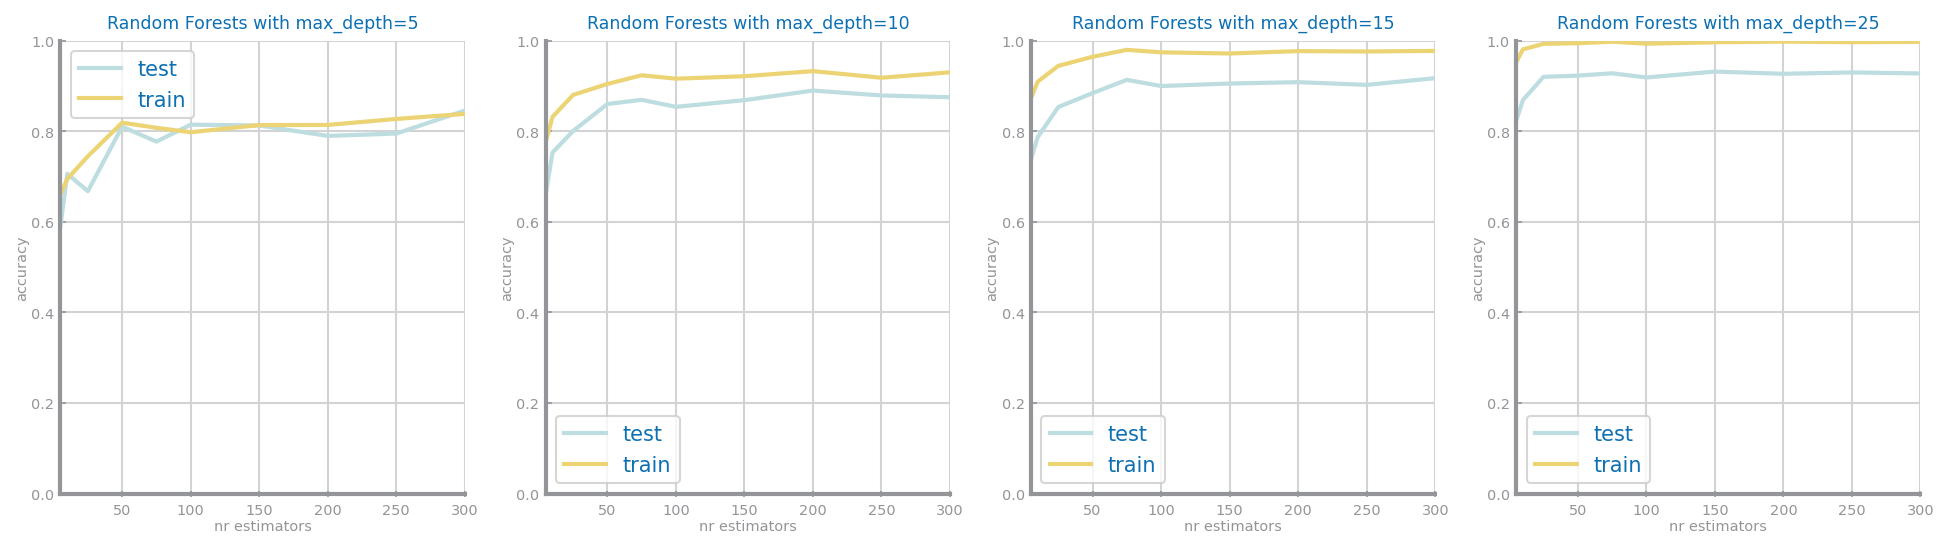

<Figure size 600x450 with 0 Axes>

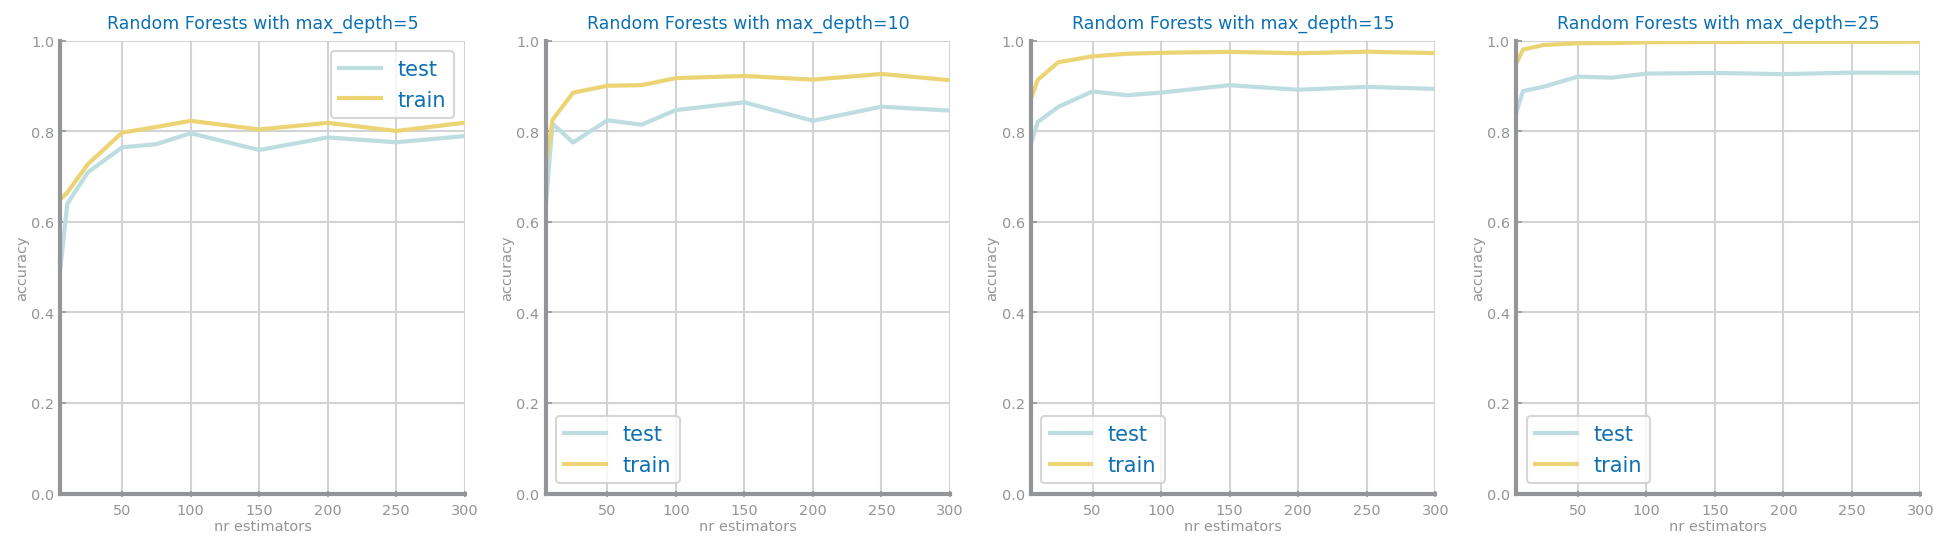

<Figure size 600x450 with 0 Axes>

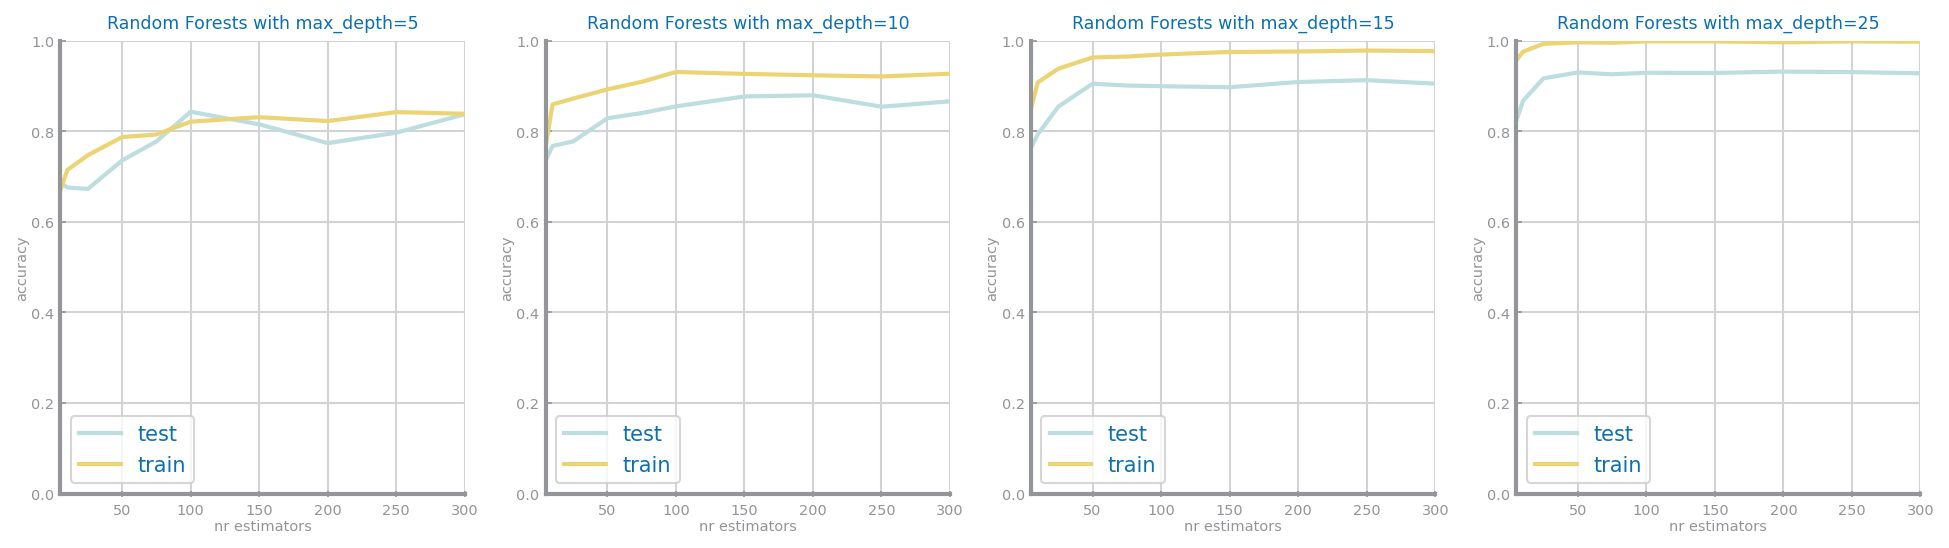

In [5]:
for i in range(n_samples):
    f = sample_best[i][1]
    plt.figure()
    fig, axs = plt.subplots(1, len(max_depths), figsize=(16, 4), squeeze=False)
    for k in range(len(max_depths)):
        d = max_depths[k]
        values = {}
        yvalues = []
        yvalues_train = []
        for n in n_estimators:
            forest = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            forest.fit(my_samples[i]['X_train'], my_samples[i]['y_train'])
            prdY = forest.predict(my_samples[i]['X_test'])
            prdY_train = forest.predict(my_samples[i]['X_train'])
            yvalues.append(metrics.accuracy_score(my_samples[i]['y_test'], prdY))
            yvalues_train.append(metrics.accuracy_score(my_samples[i]['y_train'], prdY_train))
        values['test'] = yvalues
        values['train'] = yvalues_train
        ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

    plt.show

In [6]:
mean = np.mean(sample_last_best)
std = np.std(sample_last_best)
confidences = (0.95, 0.99)
t_st = (1.812, 2.764)

print(f'Mean value: {round(mean, 3)}')

for c in range(len(confidences)):
    conf = confidences[c]
    minAcc = mean - t_st[c] * std / (10**0.5)
    maxAcc = mean + t_st[c] * std / (10**0.5)
    print(f'{int(conf*100)}% cofidence interval for accuracy: [' +
        f'{round(minAcc, 3)},{round(maxAcc, 3)}]')

Mean value: 0.93
95% cofidence interval for accuracy: [0.929,0.932]
99% cofidence interval for accuracy: [0.928,0.933]


### Summary
---

***How does performance changes with the number of estimators?***


***How does performance changes with the number of features?***


***How do models improve with the increase of max_depth?***


***What is the best parametrisation (max_depth, number of estimators and features)?***


***Is the accuracy achieved good enough?***


***What is the largest kind of errors?***


***Is it possible to identify overfitting?***
